# 画像のリサイズとパディング

指定されたディレクトリの画像のアスペクト比を維持したままリサイズし、指定された背景色でパディングするノートブックです。

## 必要なライブラリのインポート

画像処理（OpenCV）、数値計算（NumPy）、ファイル操作（os, glob）、画像表示（Matplotlib）に必要なライブラリをインポートします。

In [2]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path

## 画像ファイルのパスを取得

処理対象の画像ファイルが含まれるディレクトリを指定し、そこから画像ファイルのパスのリストを取得します。
ここでは例として `'./data/processed'` ディレクトリを使用しますが、必要に応じて変更してください。

In [3]:
from pathlib import Path

def list_images_with_pathlib(root_dir):
    p = Path(root_dir)
    # iterdir() や glob() を使えますが、再帰的には rglob を使うのが便利
    return [str(f) for f in p.rglob('*') if f.suffix.lower() in ('.jpg', '.jpeg', '.png')]

# 使用例
# images = list_images_with_pathlib('data/processed/column_images/100241706/100241706_00005_1')
# for p in images:
#     print(p)

In [4]:
# 画像ファイルが格納されているディレクトリのパス
# '@/' は通常プロジェクトルートを示すため、ここではカレントディレクトリからの相対パスを使用します
# 必要に応じて絶対パスや適切な相対パスに変更してください
image_dir = '../data/processed/column_images/100241706/100241706_00004_2' # 例: './data/processed' や '/path/to/your/images'

# 対応する画像拡張子 (必要に応じて追加・変更)
extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

image_paths = list_images_with_pathlib(image_dir)

# 取得した画像パスの数を確認
print(f"Found {len(image_paths)} images in '{image_dir}'.")

# 最初のいくつかのパスを表示（確認用）
print("First few image paths:")
for p in image_paths[:5]:
    print(p)

Found 7 images in '../data/processed/column_images/100241706/100241706_00004_2'.
First few image paths:
../data/processed/column_images/100241706/100241706_00004_2/100241706_00004_2_column_004.jpg
../data/processed/column_images/100241706/100241706_00004_2/100241706_00004_2_column_001.jpg
../data/processed/column_images/100241706/100241706_00004_2/100241706_00004_2_column_002.jpg
../data/processed/column_images/100241706/100241706_00004_2/100241706_00004_2_column_006.jpg
../data/processed/column_images/100241706/100241706_00004_2/100241706_00004_2_column_005.jpg


## リサイズとパディングを行う関数の定義

画像パス、目標サイズ（幅、高さ）、背景色を引数として受け取る関数 `resize_and_pad` を定義します。

この関数は以下の処理を行います：
1.  画像を読み込みます。
2.  元のアスペクト比を維持したまま、目標サイズ（`target_size`）に収まるように画像をリサイズします。
3.  指定された背景色（`bg_color`）で、目標サイズの背景画像を作成します。
4.  リサイズされた画像を、背景画像の中央に配置（パディング）します。
5.  処理後の画像を返します。

Average color (BGR) for ../data/processed/column_images/100241706/100241706_00004_2/100241706_00004_2_column_004.jpg: (162, 202, 214)


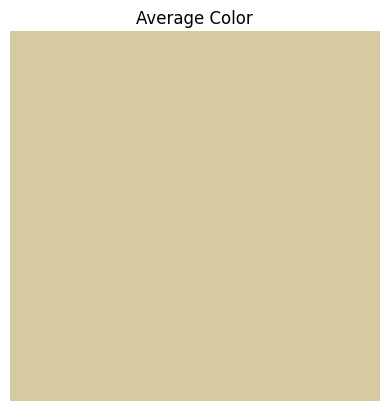

In [5]:
import cv2
import numpy as np

def calculate_average_color(image_path):
    """
    画像ファイルのパスを受け取り、全ピクセルの平均色 (BGR) を計算する関数。

    Args:
        image_path (str): 画像ファイルのパス。

    Returns:
        tuple: 平均色 (B, G, R)。画像が読み込めない場合は None。
    """
    try:
        # 画像をカラーで読み込む
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Error: Could not read image {image_path}")
            return None

        # 画像の高さと幅の軸に沿って平均値を計算 (チャンネルごとに平均)
        # 結果は [平均B, 平均G, 平均R] の NumPy 配列になる
        average_color_bgr = np.mean(img, axis=(0, 1))

        # NumPy 配列を整数のタプルに変換して返す
        return tuple(map(int, average_color_bgr))

    except Exception as e:
        print(f"Error calculating average color for {image_path}: {e}")
        return None

# 関数のテスト (最初の画像で試す)
if image_paths:
    avg_color = calculate_average_color(image_paths[0])
    if avg_color is not None:
        print(f"Average color (BGR) for {image_paths[0]}: {avg_color}")

        # 平均色で塗りつぶした画像を表示してみる (確認用)
        avg_color_patch = np.full((50, 50, 3), avg_color, dtype=np.uint8)
        plt.imshow(cv2.cvtColor(avg_color_patch, cv2.COLOR_BGR2RGB))
        plt.title("Average Color")
        plt.axis('off')
        plt.show()
else:
    print("No images found to test the average color function.")

Successfully processed ../data/processed/column_images/100241706/100241706_00004_2/100241706_00004_2_column_004.jpg. Output shape: (256, 256, 3)


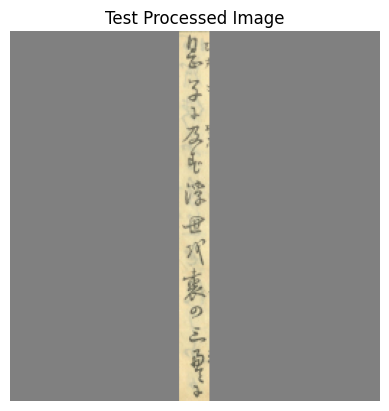

In [6]:
def resize_and_pad(image_path, target_size=(224, 224), bg_color=(255, 255, 255)):
    """
    画像を読み込み、アスペクト比を維持してリサイズし、指定された背景色でパディングする関数。

    Args:
        image_path (str): 画像ファイルのパス。
        target_size (tuple): 目標の (幅, 高さ)。
        bg_color (tuple): 背景色 (B, G, R)。OpenCVはBGR順で色を扱うため注意。

    Returns:
        numpy.ndarray: リサイズおよびパディングされた画像。エラー時は None。
    """
    try:
        # 画像を読み込む (カラーで読み込む)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Error: Could not read image {image_path}")
            return None

        h, w = img.shape[:2]
        target_w, target_h = target_size

        # アスペクト比を計算
        aspect_ratio = w / h

        # 目標サイズに合わせてリサイズ後のサイズを計算
        if aspect_ratio > (target_w / target_h):
            # 幅が基準
            new_w = target_w
            new_h = int(new_w / aspect_ratio)
        else:
            # 高さが基準
            new_h = target_h
            new_w = int(new_h * aspect_ratio)

        # 画像をリサイズ (INTER_AREA は縮小に適している)
        resized_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # 背景画像を作成 (目標サイズで、指定された背景色)
        # np.full は (高さ, 幅, チャンネル数) の順で形状を指定
        background = np.full((target_h, target_w, 3), bg_color, dtype=np.uint8)

        # リサイズされた画像を背景の中央に配置するためのオフセットを計算
        offset_x = (target_w - new_w) // 2
        offset_y = (target_h - new_h) // 2

        # 背景画像にリサイズされた画像を貼り付け
        background[offset_y:offset_y + new_h, offset_x:offset_x + new_w] = resized_img

        return background

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# 関数のテスト (最初の画像で試す)
if image_paths:
    target_w, target_h = 256, 256 # 目標サイズ
    background_color_bgr = (128, 128, 128) # 背景色 (灰色)

    processed_image = resize_and_pad(image_paths[0], target_size=(target_w, target_h), bg_color=background_color_bgr)

    if processed_image is not None:
        print(f"Successfully processed {image_paths[0]}. Output shape: {processed_image.shape}")
        # 表示のためにBGRからRGBに変換
        plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
        plt.title("Test Processed Image")
        plt.axis('off')
        plt.show()
else:
    print("No images found to test the function.")

## 画像処理の実行と結果の表示

取得した画像ファイルパスのリストをループ処理し、定義した `resize_and_pad` 関数を適用して各画像を処理します。
処理前後の画像をいくつか並べて表示し、結果を確認します。

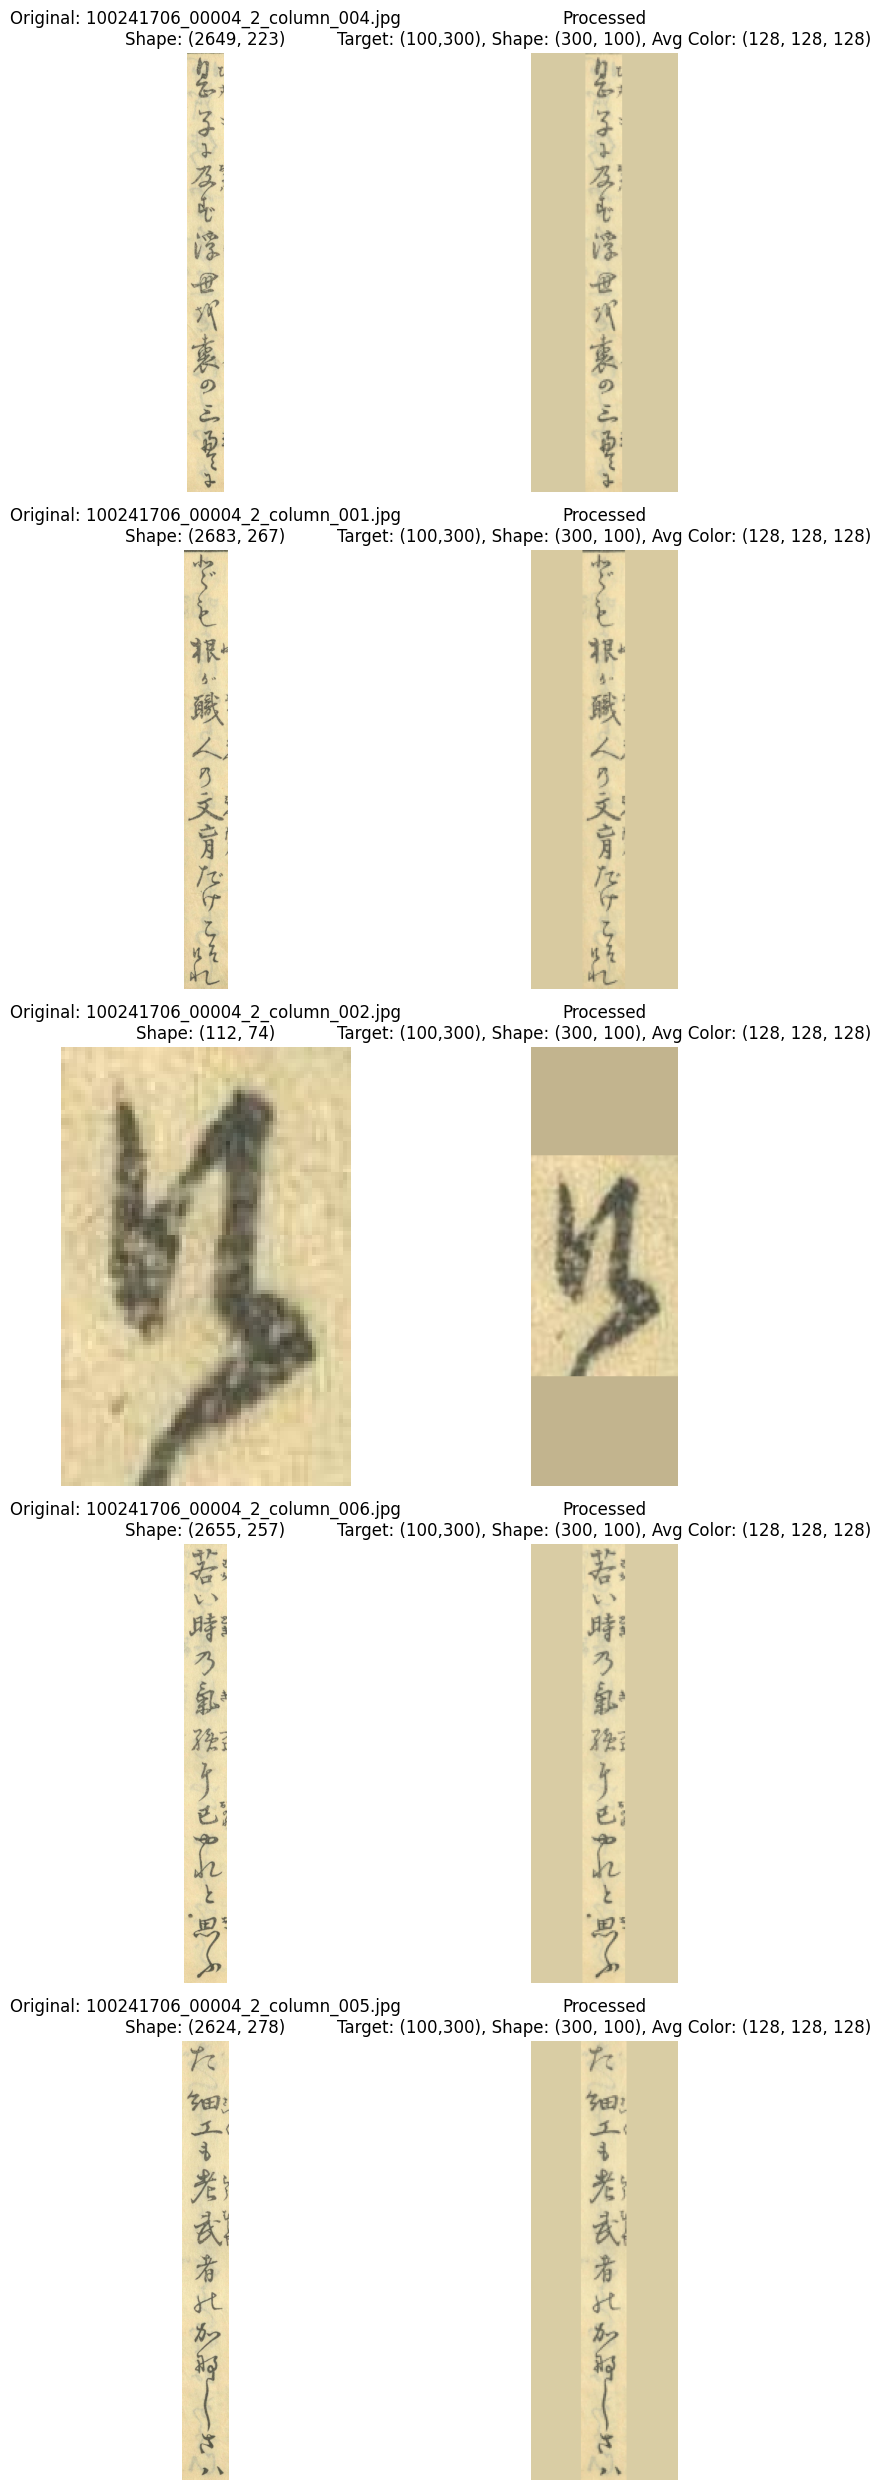

In [21]:
# 処理パラメータ
target_width = 100
target_height = 300
bg_color_bgr = (128, 128, 128) # 背景色 (BGR形式)

# 表示する画像の数
num_display = min(5, len(image_paths)) # 最大5枚、または存在する画像の数

if num_display > 0:
    plt.figure(figsize=(10, 5 * num_display))

    for i in range(num_display):
        img_path = image_paths[i]

        bg_color_bgr = calculate_average_color(img_path)

        # 元の画像を読み込み (表示用)
        original_img = cv2.imread(img_path)
        if original_img is None:
            print(f"Skipping display for {img_path} as it couldn't be read.")
            continue

        # リサイズとパディングを実行
        processed_img = resize_and_pad(img_path, target_size=(target_width, target_height), bg_color=bg_color_bgr)

        if processed_img is None:
            print(f"Skipping display for {img_path} due to processing error.")
            continue

        # 元の画像を表示 (BGR -> RGB)
        plt.subplot(num_display, 2, 2 * i + 1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Original: {os.path.basename(img_path)}\nShape: {original_img.shape[:2]}")
        plt.axis('off')

        # 処理後の画像を表示 (BGR -> RGB)
        plt.subplot(num_display, 2, 2 * i + 2)
        plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Processed\nTarget: ({target_width},{target_height}), Shape: {processed_img.shape[:2]}, Avg Color: {background_color_bgr}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No images found to process and display.")

# --- オプション: 処理結果を保存する場合 ---
# save_dir = './data/resized_padded'
# os.makedirs(save_dir, exist_ok=True)
#
# print(f"\nProcessing and saving all images to '{save_dir}'...")
# for img_path in image_paths:
#     processed_img = resize_and_pad(img_path, target_size=(target_width, target_height), bg_color=bg_color_bgr)
#     if processed_img is not None:
#         base_name = os.path.basename(img_path)
#         save_path = os.path.join(save_dir, base_name)
#         try:
#             cv2.imwrite(save_path, processed_img)
#             # print(f"Saved: {save_path}")
#         except Exception as e:
#             print(f"Error saving {save_path}: {e}")
# print("Finished processing and saving.")
# --- ここまでオプション ---

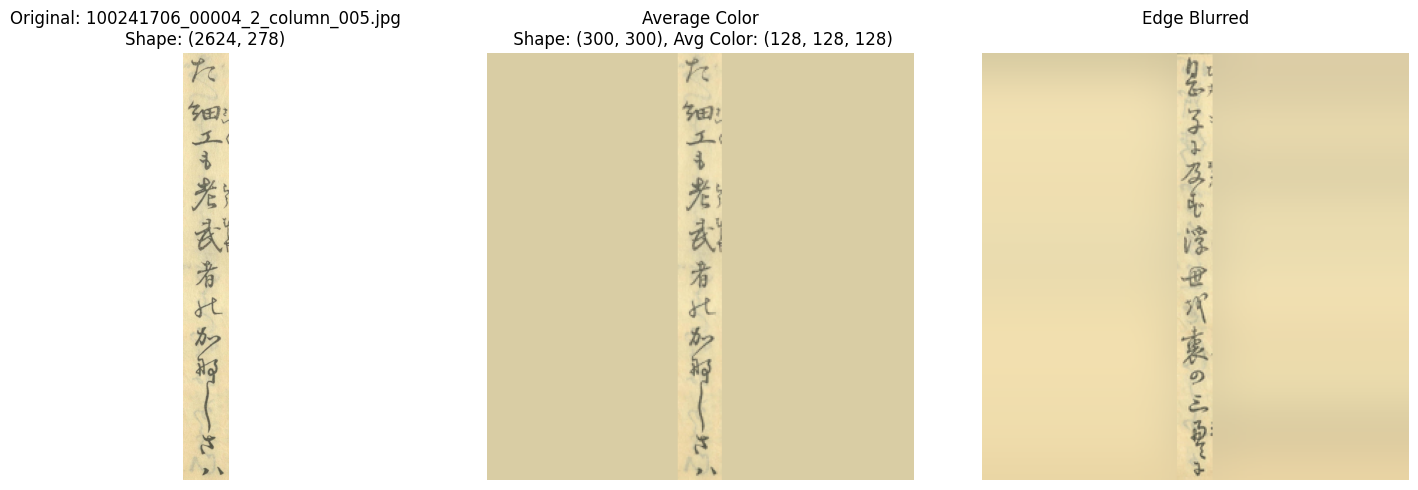

In [20]:
from PIL import Image, ImageFilter, ImageOps
import numpy as np
import matplotlib.pyplot as plt

def resize_pad_blur_edge(image_path, target_width, target_height):
    """
    和紙画像をリサイズし、エッジをぼかして拡張した背景でパディングする。
    """
    try:
        img = Image.open(image_path).convert("RGBA")
        original_width, original_height = img.size

        # --- 1. アスペクト比を保ってリサイズ ---
        ratio_w = target_width / original_width
        ratio_h = target_height / original_height
        resize_ratio = min(ratio_w, ratio_h)
        resized_width = int(original_width * resize_ratio)
        resized_height = int(original_height * resize_ratio)
        img_resized = img.resize((resized_width, resized_height), Image.Resampling.LANCZOS)

        # --- 2. 貼り付け位置の計算 ---
        paste_x = (target_width - resized_width) // 2
        paste_y = (target_height - resized_height) // 2

        # --- 3. 背景生成 (エッジ拡張 + ぼかし) ---
        # 元画像を目標サイズの中央に配置した画像を作る (周囲は一旦透明)
        background_temp = Image.new('RGBA', (target_width, target_height), (0, 0, 0, 0))
        background_temp.paste(img_resized, (paste_x, paste_y))

        # エッジピクセルで周囲を埋める (一番近いエッジピクセルの色を使う)
        # NumPyを使うと効率的
        bg_array = np.array(background_temp)
        img_array = np.array(img_resized)

        # 上下のパディング
        if paste_y > 0:
            top_edge = img_array[0, :, :]
            bg_array[0:paste_y, paste_x:paste_x+resized_width, :] = top_edge # 上端の色で上を埋める
            bottom_edge = img_array[-1, :, :]
            bg_array[paste_y+resized_height:target_height, paste_x:paste_x+resized_width, :] = bottom_edge # 下端の色で下を埋める
        # 左右のパディング
        if paste_x > 0:
            left_edge = img_array[:, 0, :]
            # 配列の形状を (height, 1, channels) に変形してブロードキャスト可能にする
            bg_array[0:target_height, 0:paste_x, :] = left_edge[:, np.newaxis, :] # 左端の色で左を埋める
            right_edge = img_array[:, -1, :]
            bg_array[0:target_height, paste_x+resized_width:target_width, :] = right_edge[:, np.newaxis, :] # 右端の色で右を埋める

        # 四隅のパディング (辺の拡張でカバーされることが多いが、念のため)
        # 左上
        if paste_x > 0 and paste_y > 0:
            bg_array[0:paste_y, 0:paste_x, :] = img_array[0, 0, :]
        # 右上
        if paste_x + resized_width < target_width and paste_y > 0:
             bg_array[0:paste_y, paste_x+resized_width:target_width, :] = img_array[0, -1, :]
        # 左下
        if paste_x > 0 and paste_y + resized_height < target_height:
             bg_array[0:paste_y, 0:paste_x, :] = img_array[-1, 0, :]
        # 右下
        if paste_x + resized_width < target_width and paste_y + resized_height < target_height:
             bg_array[paste_y+resized_height:target_height, paste_x+resized_width:target_width, :] = img_array[-1, -1, :]

        # エッジ拡張した画像をPillowオブジェクトに戻す
        background_filled = Image.fromarray(bg_array)

        # 強いぼかしをかける (ぼかし半径はパディング幅に応じて調整)
        # 例: 平均パディング幅の1/4程度の半径
        pad_width = max(paste_x, target_width - (paste_x + resized_width))
        pad_height = max(paste_y, target_height - (paste_y + resized_height))
        blur_radius = max(1, int( (pad_width + pad_height) / 2 * 0.25 )) # 0除算と最低半径1を保証
        background_blurred = background_filled.filter(ImageFilter.GaussianBlur(radius=blur_radius))

        # --- 4. 最終合成 ---
        # ぼかした背景の上に、再度クリアなリサイズ画像を貼り付ける
        final_image = background_blurred.copy() # コピーを作成
        final_image.paste(img_resized, (paste_x, paste_y), img_resized) # アルファ合成

        # RGBに戻したい場合は変換
        # return final_image.convert("RGB")
        return final_image

    except FileNotFoundError:
        print(f"エラー: 画像ファイルが見つかりません: {image_path}")
        return None
    except Exception as e:
        print(f"エラーが発生しました: {e}")
        return None

# --- 使用例 ---
if __name__ == '__main__':
    input_file = '../data/processed/column_images/100241706/100241706_00004_2/100241706_00004_2_column_004.jpg' # あなたの和紙画像のパス
    target_w = 300
    target_h = 300

    processed_image = resize_pad_blur_edge(input_file, target_w, target_h)
    
    plt.figure(figsize=(15, 5))

    mg_path = input_file

    bg_color_bgr = calculate_average_color(img_path)

    # 元の画像を読み込み (表示用)
    original_img = cv2.imread(img_path)

    # リサイズとパディングを実行
    processed_img = resize_and_pad(img_path, target_size=(target_width, target_height), bg_color=bg_color_bgr)

    # 元の画像を表示 (BGR -> RGB)
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original: {os.path.basename(img_path)}\nShape: {original_img.shape[:2]}")
    plt.axis('off')

    # 処理後の画像を表示 (BGR -> RGB)
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Average Color\n Shape: {processed_img.shape[:2]}, Avg Color: {background_color_bgr}")
    plt.axis('off')

    # エッジぼかし
    plt.subplot(1, 3, 3)
    plt.imshow(processed_image)
    plt.title("Edge Blurred\n")
    plt.axis('off')

    # 画像を表示
    plt.tight_layout()
    plt.show()

元画像の左下から (0, 2549) - (70, 2649) の範囲を切り出しました。
タイリングに使用するテクスチャサイズ: 70x100


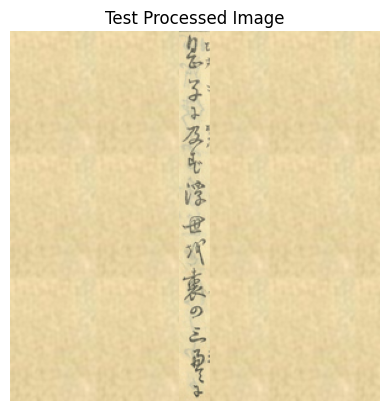

In [17]:
from PIL import Image, ImageFilter, ImageOps
import math

def resize_and_pad_texture_from_bottom_left(image_path, target_width, target_height, texture_crop_size=(100, 100), add_slight_blur=False):
    """
    和紙画像をリサイズし、元画像の【左下】から切り出した一部を
    タイリングしたテクスチャ背景でパディングする。

    Args:
        image_path (str): 元の和紙画像のパス。
        target_width (int): 目標の幅。
        target_height (int): 目標の高さ。
        texture_crop_size (tuple): 背景タイル用に切り出すテクスチャのサイズ (幅, 高さ)。
        add_slight_blur (bool): タイリング後の背景に弱いぼかしを適用するかどうか。

    Returns:
        PIL.Image.Image: 処理後の画像オブジェクト。
    """
    try:
        img = Image.open(image_path).convert("RGBA") # アルファチャンネルを考慮
        original_width, original_height = img.size

        # --- 1. アスペクト比を保ってリサイズ ---
        ratio_w = target_width / original_width
        ratio_h = target_height / original_height
        resize_ratio = min(ratio_w, ratio_h)
        resized_width = int(original_width * resize_ratio)
        resized_height = int(original_height * resize_ratio)
        img_resized = img.resize((resized_width, resized_height), Image.Resampling.LANCZOS)

        # --- 2. 貼り付け位置の計算 ---
        paste_x = (target_width - resized_width) // 2
        paste_y = (target_height - resized_height) // 2

        # --- 3. テクスチャタイルの切り出し ---
        tex_w, tex_h = texture_crop_size

        # 元画像が切り出しサイズより小さい場合は、元画像自体をタイルとする
        if original_width < tex_w or original_height < tex_h:
             print(f"警告: 元画像サイズ ({original_width}x{original_height}) が指定されたテクスチャ切り出しサイズ ({tex_w}x{tex_h}) より小さいです。元画像全体をタイル化しようと試みます。")
             texture_tile = img.copy()
             tex_w, tex_h = texture_tile.size # 実際のタイルサイズを更新
             if tex_w == 0 or tex_h == 0:
                 raise ValueError("テクスチャタイルのサイズが0になりました。")
        else:
            # 左下から切り出すように座標を計算
            crop_x = 0  # 左端
            crop_y = original_height - tex_h # 下端からタイルの高さを引いた位置が上端
            # Pillowのcropは (left, upper, right, lower) を指定
            texture_tile = img.crop((crop_x, crop_y, crop_x + tex_w, original_height))
            print(f"元画像の左下から ({crop_x}, {crop_y}) - ({crop_x + tex_w}, {original_height}) の範囲を切り出しました。")


        # --- 4. 背景画像の作成とタイリング ---
        background = Image.new('RGBA', (target_width, target_height))

        print(f"タイリングに使用するテクスチャサイズ: {tex_w}x{tex_h}")

        for y_offset in range(0, target_height, tex_h):
            for x_offset in range(0, target_width, tex_w):
                # タイルをそのまま貼り付け
                # 座標がテクスチャサイズで割り切れない場合、最後のタイルははみ出すがPillowがクリップしてくれる
                background.paste(texture_tile, (x_offset, y_offset))

        # --- 5. (オプション) 継ぎ目緩和のための弱いぼかし ---
        if add_slight_blur:
            # ぼかし半径は小さい値（例: 1 or 2）が良い
            background = background.filter(ImageFilter.GaussianBlur(radius=1))

        # --- 6. 最終合成 ---
        # タイリングした背景の上に、リサイズした画像をアルファ合成で貼り付け
        background.paste(img_resized, (paste_x, paste_y), img_resized)

        # RGBに戻したい場合は変換
        # return background.convert("RGB")
        return background # RGBAのまま返す場合

    except FileNotFoundError:
        print(f"エラー: 画像ファイルが見つかりません: {image_path}")
        return None
    except ValueError as ve:
        print(f"値エラー: {ve}")
        return None
    except Exception as e:
        print(f"エラーが発生しました: {e}")
        return None

# --- 使用例 ---
if __name__ == '__main__':
    input_file = '../data/processed/column_images/100241706/100241706_00004_2/100241706_00004_2_column_004.jpg' # あなたの和紙画像のパス
    target_w = 300
    target_h = 300
    texture_size = (70, 100) # 背景タイル用に切り出すサイズ (この値を調整)
    apply_blur = True # 継ぎ目緩和のぼかしを使うか (True/False)

    processed_image = resize_and_pad_texture_from_bottom_left(input_file, target_w, target_h, texture_crop_size=texture_size, add_slight_blur=apply_blur)

    plt.imshow(processed_image)
    plt.title("Test Processed Image")
    plt.axis('off')
    plt.show()

元画像の左下から (0, 2629) - (20, 2649) の範囲を切り出しました。
タイリングに使用するテクスチャサイズ: 20x20
元画像の左下から (0, 2663) - (20, 2683) の範囲を切り出しました。
タイリングに使用するテクスチャサイズ: 20x20
元画像の左下から (0, 92) - (20, 112) の範囲を切り出しました。
タイリングに使用するテクスチャサイズ: 20x20
元画像の左下から (0, 2635) - (20, 2655) の範囲を切り出しました。
タイリングに使用するテクスチャサイズ: 20x20
元画像の左下から (0, 2604) - (20, 2624) の範囲を切り出しました。
タイリングに使用するテクスチャサイズ: 20x20


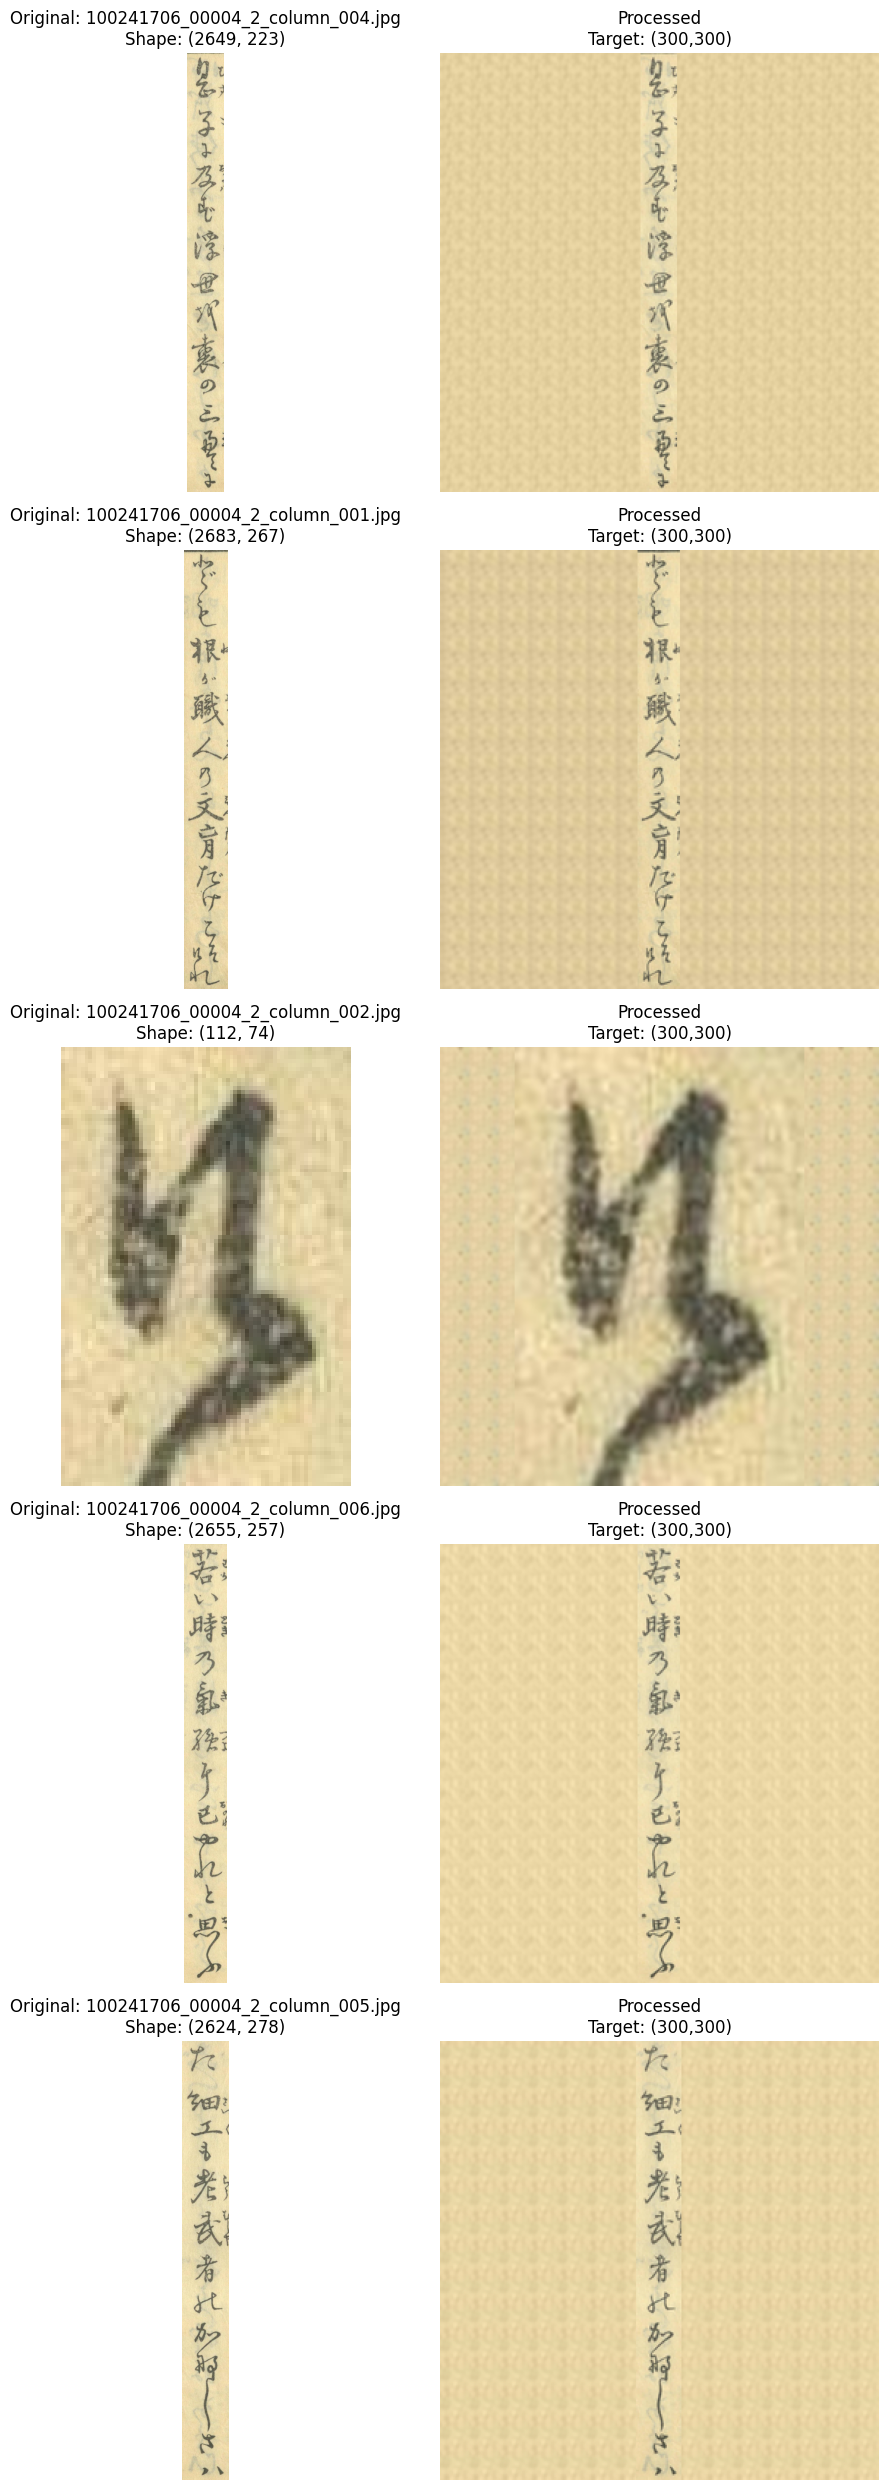

In [10]:
# 処理パラメータ
target_w = 300
target_h = 300
texture_size = (20, 20) # 背景タイル用に切り出すサイズ (この値を調整)
apply_blur = True # 継ぎ目緩和のぼかしを使うか (True/False)

# 表示する画像の数
num_display = min(5, len(image_paths)) # 最大5枚、または存在する画像の数

if num_display > 0:
    plt.figure(figsize=(10, 5 * num_display))

    for i in range(num_display):
        img_path = image_paths[i]

        # 元の画像を読み込み (表示用)
        original_img = cv2.imread(img_path)
        if original_img is None:
            print(f"Skipping display for {img_path} as it couldn't be read.")
            continue

        # リサイズとパディングを実行
        processed_img = resize_and_pad_texture_from_bottom_left(img_path, target_w, target_h, texture_crop_size=texture_size, add_slight_blur=apply_blur)

        # 元の画像を表示 (BGR -> RGB)
        plt.subplot(num_display, 2, 2 * i + 1)
        plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Original: {os.path.basename(img_path)}\nShape: {original_img.shape[:2]}")
        plt.axis('off')

        # 処理後の画像を表示 (BGR -> RGB)
        plt.subplot(num_display, 2, 2 * i + 2)
        plt.imshow(processed_img)
        plt.title(f"Processed\nTarget: ({target_width},{target_height})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No images found to process and display.")

# --- オプション: 処理結果を保存する場合 ---
# save_dir = './data/resized_padded'
# os.makedirs(save_dir, exist_ok=True)
#
# print(f"\nProcessing and saving all images to '{save_dir}'...")
# for img_path in image_paths:
#     processed_img = resize_and_pad(img_path, target_size=(target_width, target_height), bg_color=bg_color_bgr)
#     if processed_img is not None:
#         base_name = os.path.basename(img_path)
#         save_path = os.path.join(save_dir, base_name)
#         try:
#             cv2.imwrite(save_path, processed_img)
#             # print(f"Saved: {save_path}")
#         except Exception as e:
#             print(f"Error saving {save_path}: {e}")
# print("Finished processing and saving.")
# --- ここまでオプション ---

Inpainting実行中 (Method: NS, Radius: 10)...
Inpainting完了。


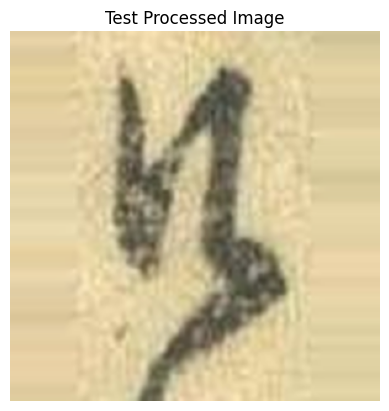

In [11]:
import cv2
import numpy as np
from PIL import Image, ImageOps

def resize_and_inpaint_background(image_path, target_width, target_height, inpaint_radius=5, method='NS'):
    """
    和紙画像をリサイズし、OpenCVのInpainting機能を使って背景を自然に拡張する。

    Args:
        image_path (str): 元の和紙画像のパス。
        target_width (int): 目標の幅。
        target_height (int): 目標の高さ。
        inpaint_radius (int): Inpaintingで考慮する近傍半径。
        method (str): Inpaintingアルゴリズム ('NS' or 'TELEA').

    Returns:
        PIL.Image.Image: 処理後の画像オブジェクト (RGBA)。
    """
    try:
        # --- 1-2. 画像読み込み (RGBA) ---
        img_rgba = Image.open(image_path).convert("RGBA")
        original_width, original_height = img_rgba.size

        # --- 3. アスペクト比を保ってリサイズ ---
        ratio_w = target_width / original_width
        ratio_h = target_height / original_height
        resize_ratio = min(ratio_w, ratio_h)
        resized_width = int(original_width * resize_ratio)
        resized_height = int(original_height * resize_ratio)
        img_resized_rgba = img_rgba.resize((resized_width, resized_height), Image.Resampling.LANCZOS)

        # --- 4. 中央配置座標計算 ---
        paste_x = (target_width - resized_width) // 2
        paste_y = (target_height - resized_height) // 2

        # --- 5. Inpainting用画像の作成 (RGB) ---
        # 背景は黒で初期化 (他の色、例えば平均色でも良い)
        image_for_inpaint_rgb = Image.new('RGB', (target_width, target_height), (0, 0, 0))
        # 中央にリサイズ画像のRGB部分を貼り付け
        image_for_inpaint_rgb.paste(img_resized_rgba.convert('RGB'), (paste_x, paste_y))

        # --- 6. マスク画像の作成 (8-bit Grayscale) ---
        mask = Image.new('L', (target_width, target_height), 255) # 全体を白(補完対象)
        mask_paste_area = Image.new('L', (resized_width, resized_height), 0) # 黒(補完しない)
        mask.paste(mask_paste_area, (paste_x, paste_y))

        # --- 7. OpenCV形式への変換 ---
        # Pillow(RGB) -> NumPy -> OpenCV(BGR)
        opencv_img_bgr = cv2.cvtColor(np.array(image_for_inpaint_rgb), cv2.COLOR_RGB2BGR)
        # Pillow(L) -> NumPy
        opencv_mask = np.array(mask)

        # --- 8. Inpaintingの実行 ---
        flags = cv2.INPAINT_NS if method.upper() == 'NS' else cv2.INPAINT_TELEA
        print(f"Inpainting実行中 (Method: {method}, Radius: {inpaint_radius})...")
        inpainted_bgr = cv2.inpaint(opencv_img_bgr, opencv_mask, inpaint_radius, flags=flags)
        print("Inpainting完了。")

        # --- 9. Pillow形式(RGBA)への変換と合成 ---
        # OpenCV(BGR) -> NumPy -> Pillow(RGB)
        inpainted_rgb = Image.fromarray(cv2.cvtColor(inpainted_bgr, cv2.COLOR_BGR2RGB))

        # 最終的なRGBA画像を作成 (Inpainting結果をベースに)
        final_rgba = inpainted_rgb.convert("RGBA")

        # 中央に元のリサイズ画像(RGBA)を貼り直して、元の透明度を復元
        final_rgba.paste(img_resized_rgba, (paste_x, paste_y), img_resized_rgba)

        # --- 10. 出力 ---
        return final_rgba

    except FileNotFoundError:
        print(f"エラー: 画像ファイルが見つかりません: {image_path}")
        return None
    except ImportError:
        print("エラー: この機能にはOpenCVライブラリが必要です。`pip install opencv-python` でインストールしてください。")
        return None
    except Exception as e:
        print(f"エラーが発生しました: {e}")
        return None

# --- 使用例 ---
if __name__ == '__main__':
    input_file = '../data/processed/column_images/100241706/100241706_00004_2/100241706_00004_2_column_002.jpg' # あなたの和紙画像のパス
    target_w = 300
    target_h = 300
    radius = 10  # Inpainting半径 (調整可能)
    inpainting_method = 'NS' # 'NS' または 'TELEA' (NSが推奨されることが多い)

    processed_image = resize_and_inpaint_background(input_file, target_w, target_h, inpaint_radius=radius, method=inpainting_method)

    plt.imshow(processed_image)
    plt.title("Test Processed Image")
    plt.axis('off')
    plt.show()

シームレス化タイルサイズ: 100x150, 使用ブレンド幅: 20


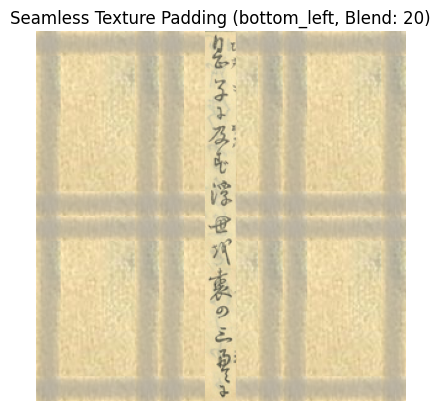

In [12]:
# matplotlibのインポートを使用例ブロックに追加
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter, ImageOps, ImageDraw
import numpy as np # NumPyを使うとグラデーション生成が楽
import traceback # エラー詳細表示のため

def create_seamless_tile(tile_image, blend_width=10):
    """
    テクスチャタイル画像の端をクロスフェードさせてシームレス化する。

    Args:
        tile_image (PIL.Image.Image): RGBA形式のタイル画像。
        blend_width (int): 端をブレンドする幅（ピクセル）。0より大きい値であること。

    Returns:
        PIL.Image.Image: シームレス化処理されたタイル画像。
    """
    # Ensure input is RGBA
    if tile_image.mode != 'RGBA':
        tile_image = tile_image.convert('RGBA')

    w, h = tile_image.size
    seamless_tile = tile_image.copy()

    # blend_widthが0以下、またはタイルサイズに対して大きすぎる場合は処理しない
    if blend_width <= 0:
        # print("情報: ブレンド幅が0以下なのでシームレス化をスキップします。")
        return seamless_tile
    # Ensure blend_width isn't too large to cause negative crop dimensions
    if w < blend_width or h < blend_width:
         print(f"警告: タイルサイズ({w}x{h})がブレンド幅({blend_width})に対して小さすぎるため、シームレス化をスキップします。")
         return seamless_tile
    # Further adjust if blend zones overlap too much
    safe_blend_width = min(blend_width, w // 2, h // 2)
    if safe_blend_width != blend_width:
         if blend_width > 0: # Only warn if user intended to blend
             print(f"警告: ブレンド幅 {blend_width} がタイルサイズ ({w}x{h}) の半分を超えています。{safe_blend_width} に調整します。")
         blend_width = safe_blend_width # Use adjusted width
         if blend_width <= 0: # Check again if adjustment made it zero
              return seamless_tile


    # --- 左右の継ぎ目を処理 ---
    # Crop strips without erroring on small dimensions after safe_blend_width check
    right_strip = seamless_tile.crop((w - blend_width, 0, w, h))
    left_strip = seamless_tile.crop((0, 0, blend_width, h))

    # Create horizontal alpha gradient mask
    alpha_mask_h = np.linspace(0, 255, blend_width, dtype=np.uint8) # Gradient from 0 to 255
    alpha_mask_h = np.tile(alpha_mask_h, (h, 1)) # Repeat vertically
    mask_h_pil = Image.fromarray(alpha_mask_h, 'L') # Convert to PIL Mask

    # Create a temporary image for the left blended edge
    temp_left = Image.new('RGBA', (blend_width, h))
    # Paste the right strip onto the temp image, using the gradient mask
    temp_left.paste(right_strip, (0, 0), mask_h_pil)
    # Paste the blended left edge onto the main tile using its own alpha
    # This line was the primary error source: used seamless_tile.split()[3] as mask
    seamless_tile.paste(temp_left, (0, 0), temp_left) # CORRECTED: Use temp_left's alpha

    # Create the inverse horizontal mask (255 down to 0)
    alpha_mask_h_inv = 255 - alpha_mask_h # Invert the gradient
    mask_h_inv_pil = Image.fromarray(alpha_mask_h_inv, 'L')

    # Create a temporary image for the right blended edge
    temp_right = Image.new('RGBA', (blend_width, h))
    # Paste the left strip onto the temp image, using the inverse gradient mask
    temp_right.paste(left_strip, (0, 0), mask_h_inv_pil)
    # Paste the blended right edge onto the main tile using its own alpha
    # This line was the primary error source: used seamless_tile.split()[3] as mask
    seamless_tile.paste(temp_right, (w - blend_width, 0), temp_right) # CORRECTED: Use temp_right's alpha

    # --- 上下の継ぎ目を処理 ---
    # Crop strips for top/bottom blending (use the potentially modified seamless_tile)
    bottom_strip = seamless_tile.crop((0, h - blend_width, w, h))
    top_strip = seamless_tile.crop((0, 0, w, blend_width))

    # Create vertical alpha gradient mask
    alpha_mask_v = np.linspace(0, 255, blend_width, dtype=np.uint8).reshape(-1, 1) # Gradient 0 to 255 (vertical)
    alpha_mask_v = np.tile(alpha_mask_v, (1, w)) # Repeat horizontally
    mask_v_pil = Image.fromarray(alpha_mask_v, 'L')

    # Create temporary image for top blended edge
    temp_top = Image.new('RGBA', (w, blend_width))
    temp_top.paste(bottom_strip, (0, 0), mask_v_pil)
    # Paste blended top edge onto the main tile using its own alpha
    # This line was the primary error source: used seamless_tile.split()[3] as mask
    seamless_tile.paste(temp_top, (0, 0), temp_top) # CORRECTED: Use temp_top's alpha

    # Create inverse vertical mask (255 down to 0)
    alpha_mask_v_inv = 255 - alpha_mask_v
    mask_v_inv_pil = Image.fromarray(alpha_mask_v_inv, 'L')

    # Create temporary image for bottom blended edge
    temp_bottom = Image.new('RGBA', (w, blend_width))
    temp_bottom.paste(top_strip, (0, 0), mask_v_inv_pil)
    # Paste blended bottom edge onto the main tile using its own alpha
    # This line was the primary error source: used seamless_tile.split()[3] as mask
    seamless_tile.paste(temp_bottom, (0, h - blend_width), temp_bottom) # CORRECTED: Use temp_bottom's alpha

    return seamless_tile


def resize_and_pad_seamless_texture(image_path, target_width, target_height, texture_crop_pos='bottom_left', texture_crop_size=(150, 150), blend_width=10):
    """
    和紙画像をリサイズし、シームレス化処理したテクスチャ背景でパディングする。
    (コメントは省略、ロジックはほぼ変更なし、エラーハンドリング強化)
    """
    try:
        img = Image.open(image_path).convert("RGBA")
        original_width, original_height = img.size

        # --- 1. アスペクト比を保ってリサイズ ---
        ratio_w = target_width / original_width if original_width > 0 else 0
        ratio_h = target_height / original_height if original_height > 0 else 0
        if ratio_w == 0 or ratio_h == 0 : # Avoid division by zero if original size is 0
             resize_ratio = 0
        else:
             resize_ratio = min(ratio_w, ratio_h)

        # Check if resize_ratio is valid
        if resize_ratio <= 0:
            print("エラー: リサイズ比率の計算に失敗しました。元画像サイズを確認してください。")
            return None

        resized_width = int(original_width * resize_ratio)
        resized_height = int(original_height * resize_ratio)
        # Ensure resized dimensions are at least 1x1
        resized_width = max(1, resized_width)
        resized_height = max(1, resized_height)
        img_resized = img.resize((resized_width, resized_height), Image.Resampling.LANCZOS)

        # --- 2. 貼り付け位置の計算 ---
        paste_x = (target_width - resized_width) // 2
        paste_y = (target_height - resized_height) // 2

        # --- 3. テクスチャタイルの切り出し ---
        req_tex_w, req_tex_h = texture_crop_size

        # Ensure requested texture size is valid
        if req_tex_w <= 0 or req_tex_h <= 0:
            print("エラー: 要求されたテクスチャサイズが無効です。")
            return None

        if original_width < req_tex_w or original_height < req_tex_h:
             print(f"警告: 元画像サイズ ({original_width}x{original_height}) が指定されたテクスチャ切り出しサイズ ({req_tex_w}x{req_tex_h}) より小さいです。元画像全体をリサイズしてタイルとします。")
             # Resize the whole image to the target texture size
             texture_tile_base = img.resize((req_tex_w, req_tex_h), Image.Resampling.LANCZOS)
        else:
            # Determine crop coordinates based on position
            if texture_crop_pos == 'center':
                crop_x = (original_width - req_tex_w) // 2
                crop_y = (original_height - req_tex_h) // 2
            elif texture_crop_pos == 'bottom_left':
                crop_x = 0
                crop_y = original_height - req_tex_h
            elif texture_crop_pos == 'top_left':
                crop_x = 0
                crop_y = 0
            elif texture_crop_pos == 'top_right':
                 crop_x = original_width - req_tex_w
                 crop_y = 0
            elif texture_crop_pos == 'bottom_right':
                 crop_x = original_width - req_tex_w
                 crop_y = original_height - req_tex_h
            else:
                print(f"警告: 不明な texture_crop_pos '{texture_crop_pos}'。中央を使用します。")
                crop_x = (original_width - req_tex_w) // 2
                crop_y = (original_height - req_tex_h) // 2

            # Ensure crop box is within image bounds (adjusting coordinates)
            crop_x = max(0, min(crop_x, original_width - req_tex_w))
            crop_y = max(0, min(crop_y, original_height - req_tex_h))
            right = crop_x + req_tex_w
            lower = crop_y + req_tex_h

            texture_tile_base = img.crop((crop_x, crop_y, right, lower))

        # Get actual tile size after cropping/resizing
        tex_w, tex_h = texture_tile_base.size
        if tex_w <= 0 or tex_h <= 0:
            print("エラー: テクスチャタイルの切り出し/リサイズに失敗しました。")
            return None

        # --- 4. テクスチャタイルのシームレス化 ---
        # Adjust blend width safely based on actual tile size
        safe_blend_width = max(0, min(blend_width, tex_w // 2, tex_h // 2))
        if safe_blend_width != blend_width and blend_width > 0:
            print(f"情報: ブレンド幅を {safe_blend_width} に調整しました。")

        seamless_texture_tile = create_seamless_tile(texture_tile_base, safe_blend_width)
        stex_w, stex_h = seamless_texture_tile.size

        # --- 5. 背景画像の作成とタイリング ---
        background = Image.new('RGBA', (target_width, target_height))

        print(f"シームレス化タイルサイズ: {stex_w}x{stex_h}, 使用ブレンド幅: {safe_blend_width}")

        if stex_w <= 0 or stex_h <= 0:
            print("エラー: シームレス化後のタイルサイズが0以下です。タイリングできません。")
            return None # Return None instead of raising ValueError to be caught by the caller

        for y_offset in range(0, target_height, stex_h):
            for x_offset in range(0, target_width, stex_w):
                background.paste(seamless_texture_tile, (x_offset, y_offset))

        # --- 6. 最終合成 ---
        background.paste(img_resized, (paste_x, paste_y), img_resized)

        return background

    except FileNotFoundError:
        print(f"エラー: 画像ファイルが見つかりません: {image_path}")
        return None
    except ImportError:
         print("エラー: このコードの実行には NumPy が必要です。 pip install numpy してください。")
         return None
    except Exception as e:
        print(f"エラーが発生しました ({type(e).__name__}): {e}")
        print("Traceback:")
        traceback.print_exc()
        return None

# --- 使用例 ---
if __name__ == '__main__':
    # matplotlibのインポート
    import matplotlib.pyplot as plt

    # ファイルパスは実行環境に合わせてください
    # 例: input_file = 'my_washi.jpg'
    input_file = '../data/processed/column_images/100241706/100241706_00004_2/100241706_00004_2_column_004.jpg'
    target_w = 300
    target_h = 300
    crop_position = 'bottom_left' # 'center', 'bottom_left', 'top_left', 'top_right', 'bottom_right'
    texture_size = (100, 150)
    blend_amount = 20

    processed_image = resize_and_pad_seamless_texture(
        input_file,
        target_w,
        target_h,
        texture_crop_pos=crop_position,
        texture_crop_size=texture_size,
        blend_width=blend_amount
    )

    if processed_image is not None:
        try:
            plt.imshow(processed_image)
            plt.title(f"Seamless Texture Padding ({crop_position}, Blend: {blend_amount})")
            plt.axis('off')
            plt.show()
            # Optionally save the image
            # output_file = 'washi_padded_seamless.png'
            # processed_image.save(output_file)
            # print(f"処理済みの画像を {output_file} として保存しました。")
        except Exception as display_error:
            print(f"画像の表示中にエラーが発生しました: {display_error}")
    else:
        print("画像の処理に失敗したため、表示できませんでした。")